In [1]:
import setGPU

import os, sys
import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D, UpSampling2D
from keras import backend as K
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras.losses import mse, binary_crossentropy
from keras.callbacks import History, TensorBoard

sys.path.append('../scripts')

from data_reading import *

setGPU: Setting GPU to: 1


Using TensorFlow backend.
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vuu/anaconda3/

In [2]:
dr = data_reading()

In [3]:
#training data
training_data_path = '../../../../data/movie_titles/ae_models_test_data'
train_data = dr.load_train_data(training_data_path)
x_train_data = np.array(train_data)
print(x_train_data.shape)

#testing data
testing_data_path = '../../../../data/movie_titles/ae_models_test_data'
test_data = dr.load_test_data(testing_data_path)
x_test_data = np.array(test_data)
print(x_test_data.shape)

(508, 128, 128, 3)
(508, 128, 128, 3)


In [4]:
#dataset
img_size = x_train_data.shape[1]
x_train = np.reshape(x_train_data, [-1, img_size, img_size, 3])
x_test = np.reshape(x_test_data, [-1, img_size, img_size, 3])
x_train = x_train_data.astype('float32') / 255
x_test = x_test_data.astype('float32') / 255
print(x_train.shape, x_test.shape)

noise_factor = 0.2
x_train_noisy = x_train + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_tran_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

(508, 128, 128, 3) (508, 128, 128, 3)


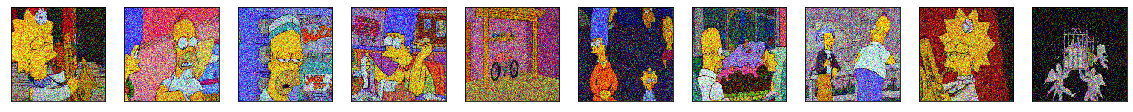

In [5]:
#display noisy images
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(128, 128, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [6]:
input_shape = (img_size, img_size, 3)
batch_size = 4
kernel_size = 3
filters = 32
latent_dim = 2
epochs = 500
print(input_shape)

(128, 128, 3)


In [7]:
def network_1():
    autoencoder = Sequential()

    # Encoder Layers
    autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=x_train_noisy.shape[1:]))
    autoencoder.add(MaxPooling2D((2, 2), padding='same'))
    
    autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    autoencoder.add(MaxPooling2D((2, 2), padding='same'))

    # Decoder Layers
    autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    autoencoder.add(UpSampling2D((2, 2)))
    
    autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    autoencoder.add(UpSampling2D((2, 2)))
    
    autoencoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

    autoencoder.summary()

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return autoencoder

In [8]:
def network_2():
    input_img = Input(shape=input_shape, name='encoder_input')

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    encoder = Model(input_img, encoded)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.summary()
    autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    
    return autoencoder

In [9]:
def network_3():
    input_img = Input(shape=input_shape, name='encoder_input')

    #encoder 5 layers with more no of feature maps
    x = Conv2D(8, (5,5), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(16, (5,5), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (5, 5), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    encoder = Model(input_img, encoded)
    #encoder.summary()

    #decoder 5 layers with more no of feature maps
    x = Conv2D(128, (5, 5), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (5, 5), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.summary()
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [10]:
autoencoder = network_1()
#autoencoder = network_2()
#autoencoder = network_3()

autoencoder.fit(x_train_noisy, x_train,
                epochs=epochs,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))
                #callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)      

Text(0.5, 1.0, 'validation loss')

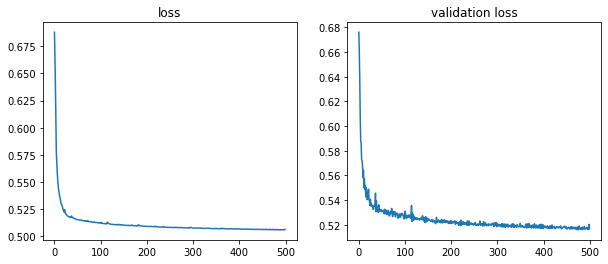

In [11]:
#print training history
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(autoencoder.history.history['loss'])
ax1.set_title('loss')
ax2 = fig.add_subplot(1, 2, 2)
plt.plot(autoencoder.history.history['val_loss'])
ax2.set_title('validation loss')

In [12]:
encoded_imgs = encoder.predict(x_test_noisy)
print(encoded_imgs.shape)
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(32, 32*128).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

NameError: name 'encoder' is not defined

In [13]:
decoded_imgs = autoencoder.predict(x_test_noisy)

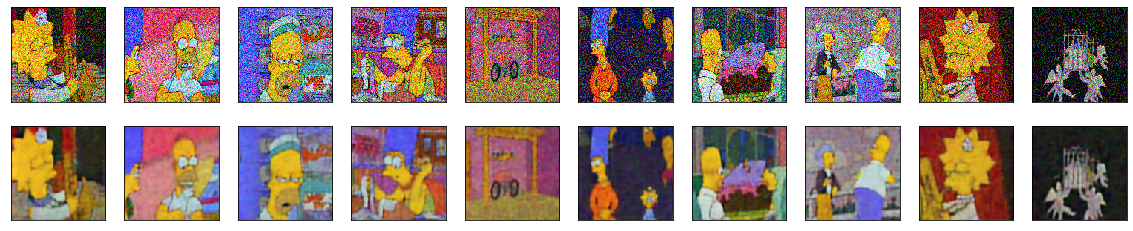

In [14]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(128,128,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(128, 128, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()